# Fashion MNIST with MLP (PyTorch)

In this example you'll train a Multi Layer Perceptron (MLP) on the Fashion MNIST.
An MLP is known as a "fully connected neural network" because every perceptron/neuron
is connected to every other perceptron in the next layer.

This is a widely used dataset, kind of like the *Hello World!* of deep learning.
The dataset contains **60k training samples** and **10k testing samples** where
each sample is a small **$28 \times 28$** grayscale image. Each sample also has
a label, which corresponds to the **class** or type of clothing shown in the
image.

Here are the classes and their integer labels:

| **Label** | **Description**  |
|-----------|------------------|
| 0         | T-shirt/top      |
| 1         | Trouser          |
| 2         | Pullover         |
| 3         | Dress            |
| 4         | Coat             |
| 5         | Sandal           |
| 6         | Shirt            |
| 7         | Sneaker          |
| 8         | Bag              |
| 9         | Ankle boot       |

Take a look at some of the samples using the dataset viewer: https://huggingface.co/datasets/zalando-datasets/fashion_mnist/viewer/fashion_mnist/train

Here are some examples (three rows of samples for each class):

![dataset preview](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

## Import Packages

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gdown
import zipfile
from tabulate import tabulate

## Dataset Setup

We will...
- download the `fashion_mnist.zip` from google drive
- unzip it into the `../dataset` directory

In [15]:
import os
dataset_downloaded = os.path.exists("../dataset")

In [16]:
# download fashion_mnist.zip file from google drive

if not dataset_downloaded:
    file_id = "1EQPgZ1401yUN0Y64YNcAIKWMuxgA4ID4"
    file_url = f"https://drive.google.com/file/d/{file_id}"  # for your reference if you want to manually download
    gdown.download(id=file_id, output="../fashion_mnist.zip")

In [17]:
# unzip the file

if not dataset_downloaded:
    zip_path = '../fashion_mnist.zip'
    extract_to = '../'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete. Take a look inside the dataset/ folder before you move on!")

## Dataset Class
In the PyTorch workflow, we always make a custom dataset that extends `torch.utils.data.Dataset`.
Every `Dataset` must implement the following methods...
- `__init__(self, ...)`: load dataset metadata and sample filepaths
- `__getitem__(self, idx)`: returns dataset sample at index: idx, we load the image from the filepath, normalize it, and also load it's label (one-hot encoded vector to represent class)
- `__len__(self)` methods: returns length of the dataset (how many samples there are)

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

class FashionDataset(Dataset):
    """MNIST Fashion Dataset
    Each sample is a tuple (x, y)
    - x is a 28x28 grayscale image (normalized to pixel values from 0-1)
    - y is an integer label representing the class of this sample
    """

    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.meta = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        filepath, label = self.meta.iloc[idx]
        image = Image.open("../" + filepath)
        transform = transforms.Compose([transforms.PILToTensor()])
        img_tensor = transform(image)[0].float() / 255.0  # Normalize
        return img_tensor, label  # Return label as an integer

In [19]:
"""
load datasets

partition semantics
-------------------
* all partitions are disjoint (no overlapping samples)
train - used to train your samples
validation - used to validate your samples (during training)
test - used to test your model (after training)

NOTE: the point of having separate validation and test sets is to avoid over-
correcting your hyperparameters to the test set. You can monitor your model's
performance during training using the validation set (which the model never 
sees in training) and then do your final test using the testing set.

For simplicity, we'll make our validation and test set the same.
"""

train_dataset = FashionDataset("../dataset/train.csv")
test_dataset = FashionDataset("../dataset/test.csv")

print(f"Lengths of datasets: {len(train_dataset)} train + {len(test_dataset)} test")

index = 32
image, label = train_dataset[index]
data = [
    ["Input Image", image.shape, image.dtype, str(image)[:500] + "..."],
    ["Output Label", label.shape, image.dtype, label],
]
print("Explore sample:")
print(
    tabulate(
        data,
        headers=["Description", "Shape", "DType", "Preview"],
        tablefmt="rounded_grid",
    )
)

Lengths of datasets: 60000 train + 10000 test
Explore sample:
╭───────────────┬──────────────────────┬───────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ Description   │ Shape                │ DType         │ Preview                                                                          │
├───────────────┼──────────────────────┼───────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Input Image   │ torch.Size([28, 28]) │ torch.float32 │ tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, │
│               │                      │               │          0.0000, 0.0000, 0.2275, 0.3451, 0.4000, 0.3059, 0.3922, 0.5020, 0.3686, │
│               │                      │               │          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000, │
│               │                      │               │          0.0000],                        

## Dataloaders

Dataloaders allow you to load your Dataset samples in *batches* (multiple 
samples at a time). Batch sizes can affect training dynamics. A rough rule to follow:
- lower batch sizes give more accurate gradient estimates, which can help the model converge better but may result in slower training.
- higher batch sizes speed up training by using hardware more efficiently, but they may lead to less accurate gradient estimates and poorer generalization.

In [20]:
hyper_params = {
    "batch_size": 128,
    "lr": 0.001,
    "num_epochs": 10,
}

train_loader = DataLoader(
    train_dataset,
    batch_size=hyper_params["batch_size"],
    shuffle=True,
)
val_loader = DataLoader(
    test_dataset,
    batch_size=hyper_params["batch_size"],
)  # no need to shuffle

# get a single "batch" and explore it
for images, labels in train_loader:
    data = [
        [
            "Input Images (batched)",
            images.shape,
            images.dtype,
            str(image)[:500] + "...",
        ],
        [
            "Output Labels (batched)",
            labels.shape,
            labels.dtype,
            str(labels)[:100] + "...",
        ],
    ]
    print("Explore sample batch:")
    print(
        tabulate(
            data,
            headers=["Description", "Shape", "DType", "Preview"],
            tablefmt="rounded_grid",
        )
    )
    break

Explore sample batch:
╭─────────────────────────┬───────────────────────────┬───────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ Description             │ Shape                     │ DType         │ Preview                                                                          │
├─────────────────────────┼───────────────────────────┼───────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Input Images (batched)  │ torch.Size([128, 28, 28]) │ torch.float32 │ tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, │
│                         │                           │               │          0.0000, 0.0000, 0.2275, 0.3451, 0.4000, 0.3059, 0.3922, 0.5020, 0.3686, │
│                         │                           │               │          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000, │
│                         │                     

## Initialize Model

We've provided some boilerplate. Your job is to choose your optimizer and model architecture.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CustomMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

        self.optim = optim.Adam(self.mlp.parameters())

        self.metrics = {
            "train": {"losses": [], "accuracies": []},
            "val": {"losses": [], "accuracies": []},
        }

    def forward(self, image):
        assert len(image.shape) == 3, "Input of shape (B, 28, 28) expected."
        return self.mlp(image)

In [22]:
# test a simple forward pass
model = CustomMLP()
sample_image = train_dataset[0][0].reshape(
    (1, 28, 28)
)  # reshape to add batch dimension of 1
sample_output = model(sample_image)
predicted_label = sample_output.argmax(dim=1)

print(
    tabulate(
        [
            ["Image shape:", sample_image.shape],
            ["Output:", sample_output],
            ["Output shape:", sample_output.shape],
            ["Predicted label:", predicted_label]
        ],
        tablefmt="rounded_grid",
    )
)

╭──────────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ Image shape:     │ torch.Size([1, 28, 28])                                                          │
├──────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Output:          │ tensor([[ 0.0236, -0.2307,  0.0298,  0.0081, -0.1521,  0.1047, -0.1653,  0.0031, │
│                  │           0.1428, -0.0324]], grad_fn=<AddmmBackward0>)                           │
├──────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Output shape:    │ torch.Size([1, 10])                                                              │
├──────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Predicted label: │ tensor([8])                                                                      │
╰──────────────────┴────────────────────────────────────────────

## Training and Validation

In [23]:
"""
train method
-----------
- gets called once every training "epoch"
- An epoch refers to a complete pass through the entire training dataset. 
- During an epoch, the model processes batches of data sequentially, computes gradients, and updates parameters.
"""

from tqdm import tqdm


def train(model, dataloader, device):
    model.train()
    epoch_correct = 0
    epoch_loss = 0

    for image_batch, label_batch in tqdm(dataloader):
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        model.optim.zero_grad()
        output = model(image_batch)
        loss = F.cross_entropy(output, label_batch)  # TODO: compute loss with loss function of your choice
        epoch_loss += float(loss.data) / dataloader.batch_size
        loss.backward()
        model.optim.step()

        predicted_labels = output.argmax(dim=1)
        iteration_correct = (predicted_labels == label_batch).sum().item()
        epoch_correct += iteration_correct

    # for metric plotting at end
    model.metrics["train"]["losses"].append(epoch_loss / len(dataloader.dataset))
    model.metrics["train"]["accuracies"].append(
        100 * epoch_correct / len(dataloader.dataset)
    )


def validate(model, dataloader, device):
    model.eval()
    epoch_correct = 0
    epoch_loss = 0

    with torch.no_grad():
        for image_batch, label_batch in tqdm(dataloader):
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)
            output = model(image_batch)
            loss = F.cross_entropy(output, label_batch)
            epoch_loss += float(loss.data) / dataloader.batch_size

            predicted_labels = output.argmax(dim=1)
            iteration_correct = (predicted_labels == label_batch).sum().item()
            epoch_correct += iteration_correct

    model.metrics["val"]["losses"].append(epoch_loss / len(dataloader.dataset))
    model.metrics["val"]["accuracies"].append(
        100 * epoch_correct / len(dataloader.dataset)
    )

## Train Models!

Now that you've setup your datasets, dataloaders, model, training and 
validation steps, and chosen your optimizer loss criterion, it's time to actually
train for a number of epochs. 

Since you saved your training and validation accuracies and losses, we can also 
generate some useful plots to analyze how well your model is learning!

In [24]:
# first we choose an acceleration device if it is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (NVIDIA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU (generic)")
    
# move model to device
model = model.to(device)

Using MPS (Apple Metal)


In [25]:
print("Training with the following hyperparameters:")
table = [[key, value] for key, value in hyper_params.items()]
print(tabulate(table, headers=["Hyperparameter", "Value"], tablefmt="simple_grid"))


for i in range(hyper_params["num_epochs"]):
    print(f"Epoch {i+1} ------------------------------------------------------")
    train(model, train_loader, device)
    print(
        tabulate(
            [
                ["Train Accuracy", f"{model.metrics['train']['accuracies'][-1]}%"],
                ["Train Loss", f"{model.metrics['train']['losses'][-1]:.4f}"],
            ],
            tablefmt="rounded_grid",
        )
    )

    validate(model, val_loader, device)
    print(
        tabulate(
            [
                ["Validation Accuracy", f"{model.metrics['val']['accuracies'][-1]}%"],
                ["Validation Loss", f"{model.metrics['val']['losses'][-1]:.4f}"],
            ],
            tablefmt="simple_grid",
        )
    )

Training with the following hyperparameters:
┌──────────────────┬─────────┐
│ Hyperparameter   │   Value │
├──────────────────┼─────────┤
│ batch_size       │ 128     │
├──────────────────┼─────────┤
│ lr               │   0.001 │
├──────────────────┼─────────┤
│ num_epochs       │  10     │
└──────────────────┴─────────┘
Epoch 1 ------------------------------------------------------


100%|██████████| 469/469 [00:17<00:00, 27.34it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 77.57166666666667% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 35.64it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 81.17% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 2 ------------------------------------------------------


100%|██████████| 469/469 [00:15<00:00, 29.98it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 84.70833333333333% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 32.18it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 84.93% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 3 ------------------------------------------------------


100%|██████████| 469/469 [00:18<00:00, 26.03it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 86.15333333333334% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 35.94it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 85.12% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 4 ------------------------------------------------------


100%|██████████| 469/469 [00:14<00:00, 32.42it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 86.96666666666667% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 33.74it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 85.39% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 5 ------------------------------------------------------


100%|██████████| 469/469 [00:15<00:00, 30.54it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 87.70333333333333% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 34.57it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 86.99% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 6 ------------------------------------------------------


100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 88.21333333333334% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 38.07it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 86.86% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 7 ------------------------------------------------------


100%|██████████| 469/469 [00:16<00:00, 28.96it/s]


╭────────────────┬────────╮
│ Train Accuracy │ 88.61% │
├────────────────┼────────┤
│ Train Loss     │ 0.0000 │
╰────────────────┴────────╯


100%|██████████| 79/79 [00:02<00:00, 35.96it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 87.57% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 8 ------------------------------------------------------


100%|██████████| 469/469 [00:14<00:00, 32.79it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 88.80333333333333% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 38.10it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 86.94% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 9 ------------------------------------------------------


100%|██████████| 469/469 [00:14<00:00, 33.09it/s]


╭────────────────┬────────────────────╮
│ Train Accuracy │ 89.18166666666667% │
├────────────────┼────────────────────┤
│ Train Loss     │ 0.0000             │
╰────────────────┴────────────────────╯


100%|██████████| 79/79 [00:02<00:00, 37.74it/s]


┌─────────────────────┬────────┐
│ Validation Accuracy │ 86.88% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘
Epoch 10 ------------------------------------------------------


100%|██████████| 469/469 [00:14<00:00, 33.20it/s]


╭────────────────┬────────╮
│ Train Accuracy │ 89.45% │
├────────────────┼────────┤
│ Train Loss     │ 0.0000 │
╰────────────────┴────────╯


100%|██████████| 79/79 [00:02<00:00, 34.60it/s]

┌─────────────────────┬────────┐
│ Validation Accuracy │ 87.11% │
├─────────────────────┼────────┤
│ Validation Loss     │ 0.0000 │
└─────────────────────┴────────┘


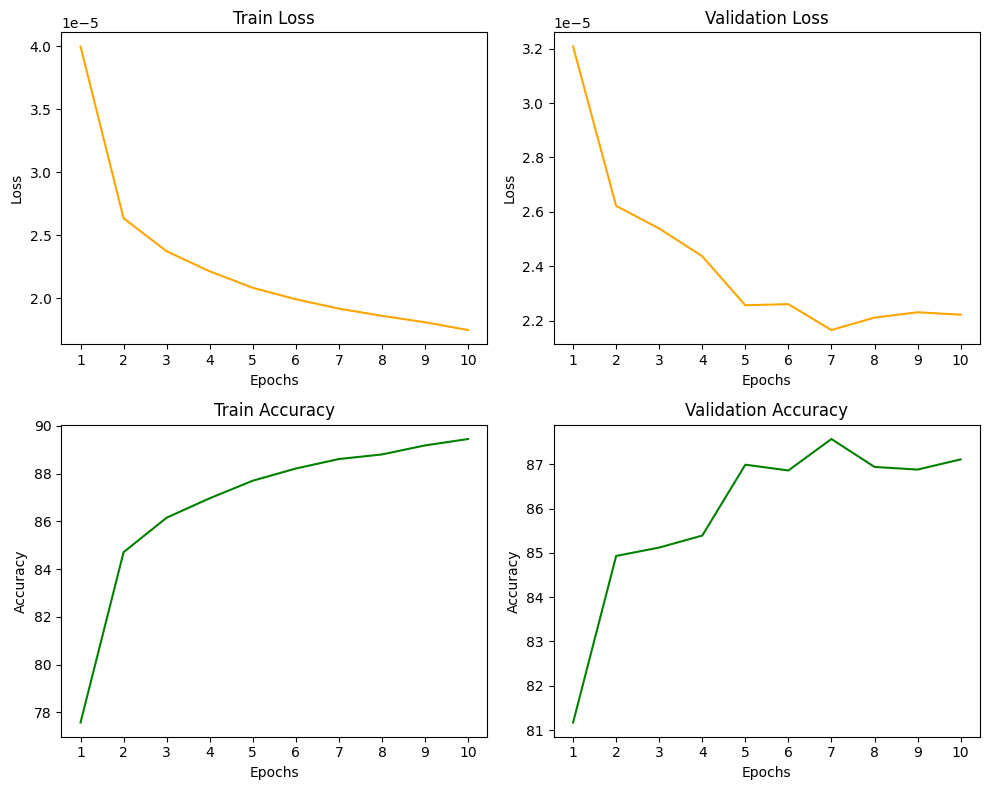

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(model.metrics["train"]["losses"]) + 1)
train_losses = model.metrics["train"]["losses"]
val_losses = model.metrics["val"]["losses"]
train_accuracies = model.metrics["train"]["accuracies"]
val_accuracies = model.metrics["val"]["accuracies"]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

loss_color = "orange"
accuracy_color = "green"

# Plot train losses
axes[0, 0].plot(epochs, train_losses, label="Train Loss", color=loss_color)
axes[0, 0].set_title("Train Loss")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_xticks(epochs)

# Plot val losses
axes[0, 1].plot(epochs, val_losses, label="Val Loss", color=loss_color)
axes[0, 1].set_title("Validation Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].set_xticks(epochs)

# Plot train accuracies
axes[1, 0].plot(epochs, train_accuracies, label="Train Accuracy", color=accuracy_color)
axes[1, 0].set_title("Train Accuracy")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].set_xticks(epochs)

# Plot val accuracies
axes[1, 1].plot(epochs, val_accuracies, label="Val Accuracy", color=accuracy_color)
axes[1, 1].set_title("Validation Accuracy")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].set_xticks(epochs)

# Adjust layout
plt.tight_layout()
plt.show()